In [1]:
import sys, os, time, shutil, random
# os.environ['PLETHORA_PATH'] = r'C:\Users\anwan\Documents\workspace\local_data'
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn, optim as opt
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# from src.helix import helix_labels, helix_observations, ToyVAE
from src.shapes import ShapesVAE, Shapes3D

import omnifig as fig

from omnilearn import util

2022-06-30 08:25:55.822233: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /is/ei/fleeb/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/is/ei/fleeb/.mujoco/mujoco200/bin
2022-06-30 08:25:55.822248: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
device = 'cuda'

In [3]:
model = ShapesVAE()
model.load_state_dict(torch.load('model_a.pt'))
model.to(device)

ShapesVAE(
  (encoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2

In [57]:
util.count_parameters(model)

510067

In [4]:
# from plethora import datasets
# dataset = datasets.Shapes3D(download=False, mode=None).prepare()
# len(dataset)

In [5]:
# data = Shapes3D(download=False, root=r'C:\Users\anwan\Documents\workspace\local_data\3dshapes')
data = Shapes3D(download=False, root='/is/ei/fleeb/workspace/local_data/3dshapes')
# data = Shapes3D(download=False)

In [6]:
X, _ = data[torch.randint(len(data), size=(10000,))]
X.shape

torch.Size([10000, 3, 64, 64])

In [9]:
loader = DataLoader(TensorDataset(X), batch_size=100)
Zmu, Zsigma = [], []
for x, in tqdm(loader, total=len(loader)):
    with torch.no_grad():
        z = model.encode(x.cuda())
#         Zmu, Zsigma = Z.loc.cpu(), Z.scale.cpu()
        Zmu.append(z.loc.cpu())
        Zsigma.append(z.scale.cpu())
Zmu = torch.cat(Zmu)
Zsigma = torch.cat(Zsigma)
Zmu.shape

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 24])

In [ ]:
# plt.figure()
# plt.title('Posterior')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.xlim(xvals.min(),xvals.max(),)
# plt.ylim(yvals.min(),yvals.max())
# # plt.imshow(mags, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# badsel = np.ones((*happy.shape,4))
# badsel[...,-1] = 0.
# badsel[~happy] = [1,0,0,1]
# plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
# #            cmap='Reds', alpha=0.8, 
#            extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# # plt.imshow(mags);
# plt.tight_layout()


In [37]:
import numpy as np
from scipy.linalg import qr

np.random.seed(11)

n = 24
H = np.random.randn(n, n)
Q, R = qr(H)
basis = torch.as_tensor(Q).float()
basis.shape

torch.Size([24, 24])

In [38]:
# util.plot_mat(Q@Q.T, val_fmt=2)

In [39]:
rZmu = Zmu @ basis
rZsigma = Zsigma @ basis
rZmu.shape

torch.Size([10000, 24])

In [55]:
dims = 13, 14
dims = 16, 22
dims = 15, 23
# dims = 2, 9
dims

(15, 23)

In [52]:
r = 3
xlims = -r, r
ylims = -r, r

aspect_ratio = 'auto'
aspect_ratio = 'equal'

In [53]:
# zs = Z.sample((10,)).cpu()[...,dims].view(-1,len(dims))
# zs.shape
# plt.figure()
# sns.kdeplot(x=zs[...,0], y=zs[...,1], cmap="Reds", shade=True, bw_adjust=.2)
# n = 60
# plt.figure()
# hist, *other = np.histogram2d(*zs.t().numpy(), bins=n, normed=True, range=torch.as_tensor([xlims, ylims]).cpu().numpy())
# plt.imshow(hist.T[::-1], cmap='Blues', interpolation = "gaussian", 
#            extent=[*xlims, *ylims], aspect=aspect_ratio)

<IPython.core.display.Javascript object>


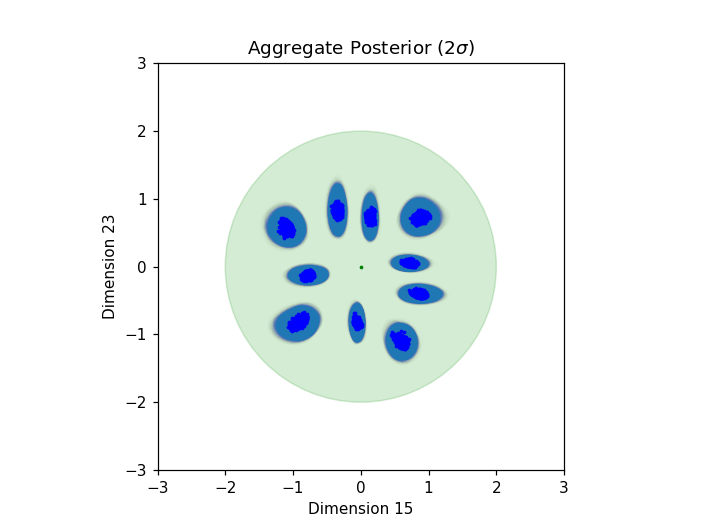

In [56]:

plt.figure()
plt.gca().set_aspect(aspect_ratio)

conf = 2

locs = Zmu[...,dims]
widths = Zsigma[...,dims]*conf*2

# locs = rZmu[...,dims]
# widths = rZsigma[...,dims]*conf*2


# Qlbls = ms.predict(locs.numpy())
alpha = max(10/len(locs), 0.005)
for c, s in zip(locs, widths):
    e = mpatches.Ellipse(c, *s, alpha=alpha, color='C0')#color=colors[l])
    plt.gca().add_artist(e)
plt.scatter(*locs.t(), marker='o', color='b', s=2, zorder=2)
# plt.scatter(*zs.t(), marker='.', color='C0', s=1, zorder=2)
plt.title(f'Aggregate Posterior (${conf}\\sigma$)')

plt.scatter(0,0, marker='o', color='g', s=2, zorder=2)
e = mpatches.Ellipse((0,0), 2*conf,2*conf, alpha=0.2, color='C2', zorder=-2)#color=colors[l])
plt.gca().add_artist(e)

plt.xlabel(f'Dimension {dims[0]}')
plt.ylabel(f'Dimension {dims[1]}')

plt.xlim(*xlims)
plt.ylim(*ylims);